In [203]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import eurostat
import requests
import re
import time
from io import StringIO
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as mtick

## Time-series Analysis

### Introduction to Time-series

There are several data processing to handle when working with time-series data. The basic steps include:

* Data types for timestamps and time-series values should be in appropriate types.
* Data should be in **chronological order** and **equidistant timestamps**.
* Missing data is a little bit tricky to find; considering filling or dropping depending on your downstream process.

For more information: 

* [Introduction to Time-series Forecasting](https://www.kaggle.com/code/iamleonie/intro-to-time-series-forecasting#Data-Preprocessing)
* [Comprehensive Pandas Guide to Manipulate Time-series Data](https://pandas.pydata.org/docs/user_guide/timeseries.html)

In [17]:
# nvo_df = yf.download(tickers="NVO", start="2020-01-01", end="2024-01-01", interval="1d")
nvo_df = yf.download(tickers="NVO", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [18]:
# Data from yfinance or API in general already gives a proper data type.
# No missing data
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10843 entries, 1981-04-30 to 2024-05-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10843 non-null  float64
 1   High       10843 non-null  float64
 2   Low        10843 non-null  float64
 3   Close      10843 non-null  float64
 4   Adj Close  10843 non-null  float64
 5   Volume     10843 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 593.0 KB


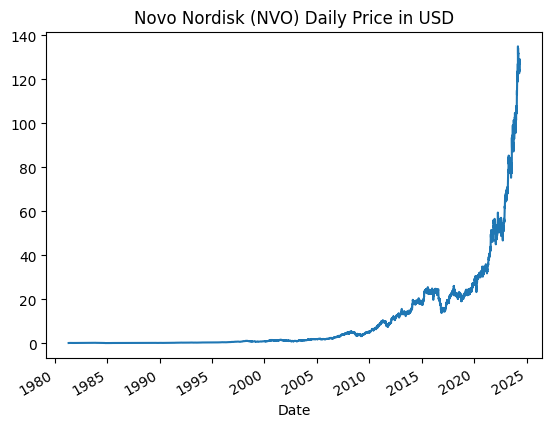

In [19]:
nvo_df["Adj Close"].plot(title="Novo Nordisk (NVO) Daily Price in USD")
plt.show()

In [20]:
# Create multiple time-series; adding ticker as a key
nvo_df["Ticker"] = "NVO"

# Build datetime features
nvo_df = nvo_df.reset_index()
nvo_df["Year"] = nvo_df["Date"].dt.year
nvo_df["Month"] = nvo_df["Date"].dt.month
nvo_df["Weekday"] = nvo_df["Date"].dt.weekday

# Historical growth for analysis
nvo_df["1DGrowth"] = nvo_df["Adj Close"] / nvo_df["Adj Close"].shift(1)
nvo_df["30DGrowth"] = nvo_df["Adj Close"] / nvo_df["Adj Close"].shift(30)

# Future growth for modelling; regression or binary classification
nvo_df["1d_future_growth"] = nvo_df["Adj Close"].shift(-1) / nvo_df["Adj Close"]
nvo_df["is_positive_1d_future_growth"] = np.where(nvo_df["1d_future_growth"] > 1, 1, 0)

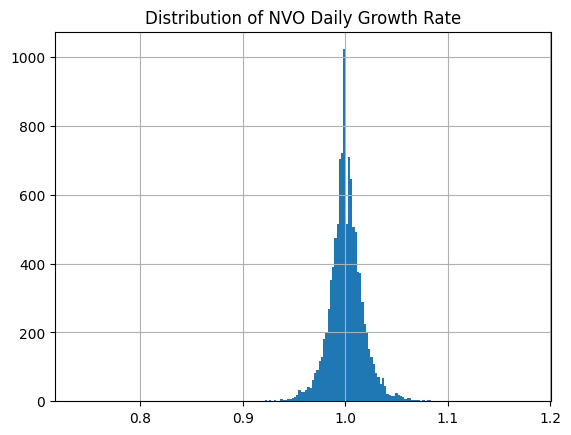

In [21]:
nvo_df["1DGrowth"].hist(bins=200)

plt.title("Distribution of NVO Daily Growth Rate")
plt.show()

As you can see, normally *NVO* daily growth is around 0%. In other words, it is moving in sideway on a daily basis.

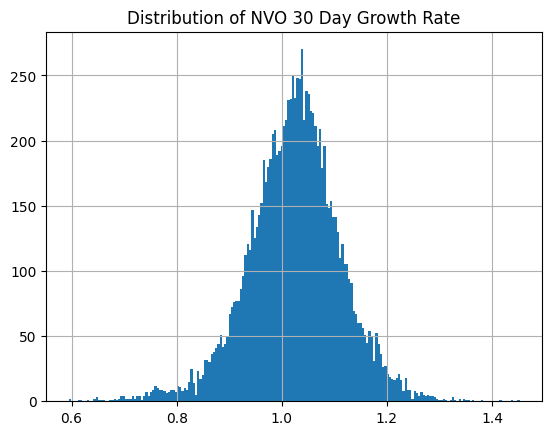

In [24]:
nvo_df["30DGrowth"].hist(bins=200)

plt.title("Distribution of NVO 30 Day Growth Rate")
plt.show()

Roughly *NVO* has an uptrend around 2-3% on a monthly basis. You can use `1DGrowth` and `30DGrowth` as features to your model. For example, let predict at a particular timestamp whether it will has a positive 1DGrowth given those features.

Note that absolute number of prices should not be used as a feature. The reason is that in the long-run, prices usually go up so it is non-stationary by nature. This causes a potential problem when modelling with low values and inferencing with higher values.

In [34]:
# Balance Labelled dataset
nvo_df["is_positive_1d_future_growth"].value_counts() / len(nvo_df)

is_positive_1d_future_growth
0    0.512865
1    0.487135
Name: count, dtype: float64

### Candlestick chart for OHLCV

In [41]:
subset_nvo_df = nvo_df[(nvo_df["Date"] >= pd.to_datetime("2020-01-01")) & (nvo_df["Date"] < pd.to_datetime("2024-01-01"))]

In [42]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
fig = go.Figure(data=[go.Candlestick(x=subset_nvo_df.Date,
                open=subset_nvo_df.Open,
                high=subset_nvo_df.High,
                low=subset_nvo_df.Low,
                close=subset_nvo_df.Close)
               ])

fig.update_layout(
    title="NVO Daily Price in USD",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

## Data Sources

### IPOs (Initial Public Offerings)

In [43]:
def scrape_table(url):
    """
    Scrape html tables from the given url.
    """
    # Read a web page
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    }
    response = requests.request("GET", url, headers=headers)

    # Parse scraping html to pandas DataFrame
    if response.status_code == 200:
        dfs = pd.read_html(StringIO(response.text))
    else:
        raise ValueError(f"Unable to scape the page!")
    
    return dfs

In [90]:
# Get data
main_url = "https://stockanalysis.com/ipos/"
ipos_years = ["2023", "2024"]

ipos_dfs = [scape_table(main_url + ipo_year)[0] for ipo_year in ipos_years]
ipos_df = pd.concat(ipos_dfs, ignore_index=True)

In [91]:
ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      218 non-null    object
 1   Symbol        218 non-null    object
 2   Company Name  218 non-null    object
 3   IPO Price     218 non-null    object
 4   Current       218 non-null    object
 5   Return        218 non-null    object
dtypes: object(6)
memory usage: 10.3+ KB


In [92]:
# Price sometimes are not filled with a numerical value
ipos_df["IPO Price"] = ipos_df["IPO Price"].replace('-', np.NaN)

# Clean out a dollar sign and a percentage sign
ipos_df["IPO Price"] = ipos_df["IPO Price"].str.replace('$', '')
ipos_df["Current"] = ipos_df["Current"].str.replace('$', '')
ipos_df["Return"] = ipos_df["Return"].str.replace('%', '')

# Cast data type
ipos_df["IPO Date"] = pd.to_datetime(ipos_df["IPO Date"])
ipos_df["IPO Price"] = pd.to_numeric(ipos_df["IPO Price"], errors="coerce")
ipos_df["Current"] = pd.to_numeric(ipos_df["Current"], errors="coerce")
ipos_df["Return"] = pd.to_numeric(ipos_df["Return"], errors="coerce") / 100

Note that sometimes error can be hard to detect. So, when you done with the clening process and hopefully all errors are solved, casting type via setting the `errors` to "coerce" will help automatically clean out problmatic values to NaN. This is helpful when you don't have time to go over the data in details and you can still handle NaN in the last data processing step.

In [93]:
ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       0
Current         0
Return          1
dtype: int64

In [94]:
# Handle missing values; Do you want to leave the record? How to do you fill the value in?
ipos_df[ipos_df["Return"].isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
167,2024-04-17,JUNE,Junee Limited,4.0,4.0,NaN


In [95]:
# Descriptive analysis
ipos_df.describe()

,IPO Date,IPO Price,Current,Return
count,218,218.000000,218.000000,217.000000
mean,2023-09-08 03:44:35.229357824,11.060229,11.067248,-0.201381
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600
25%,2023-04-20 00:00:00,4.000000,1.235000,-0.730000
50%,2023-09-14 12:00:00,8.000000,5.715000,-0.230000
75%,2024-01-24 18:00:00,13.750000,10.840000,0.057000
max,2024-05-01 00:00:00,92.000000,116.530000,4.517500
std,NaN,11.245650,16.979414,0.707737


In [107]:
# How many IPOs for each month?
ipos_df["monthly_date"] = ipos_df["IPO Date"].dt.to_period('M').dt.to_timestamp()
monthly_deals_df = ipos_df["monthly_date"].value_counts().reset_index().sort_values(by="monthly_date")
monthly_deals_df = monthly_deals_df.rename(columns={"count": "n"})

fig = px.bar(
    monthly_deals_df, 
    x="monthly_date", 
    y="n", 
    title="Number of IPOs deals on Monthly Period", 
)

fig.update_traces(
    textposition='outside', # Position the text outside the bars
    textfont=dict(color='black',size=14), # Adjust the font size of the text
)
fig.update_layout(title_x=0.5) # Center the title
fig.show()

### Macroeconomics Indicators

[*********************100%%**********************]  1 of 1 completed


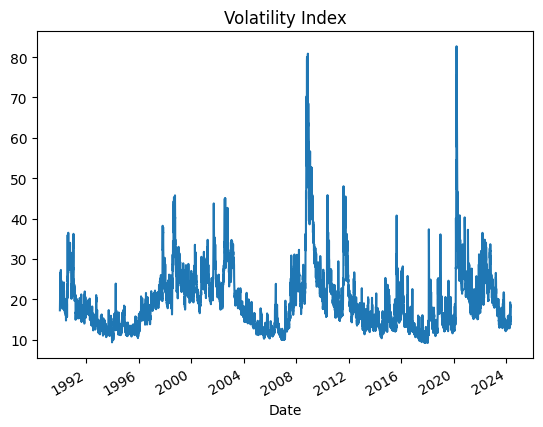

In [113]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
vix_df = yf.download(tickers="^VIX", period="max", interval="1d")

vix_df["Adj Close"].plot(title="Volatility Index")
plt.show()

[*********************100%%**********************]  1 of 1 completed


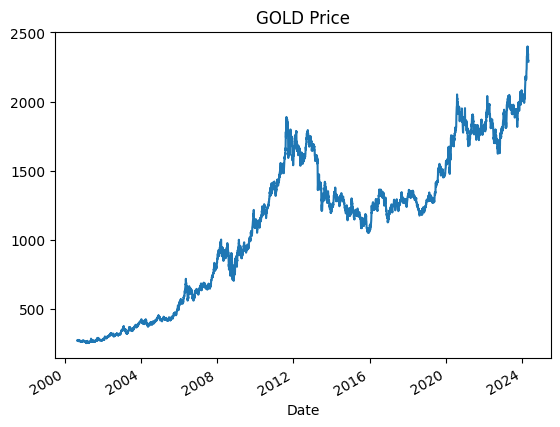

In [117]:
# GOLD
# https://finance.yahoo.com/quote/GC%3DF
gold_df = yf.download(tickers="GC=F", period="max", interval="1d")

gold_df["Adj Close"].plot(title="GOLD Price")
plt.show()

[*********************100%%**********************]  1 of 1 completed


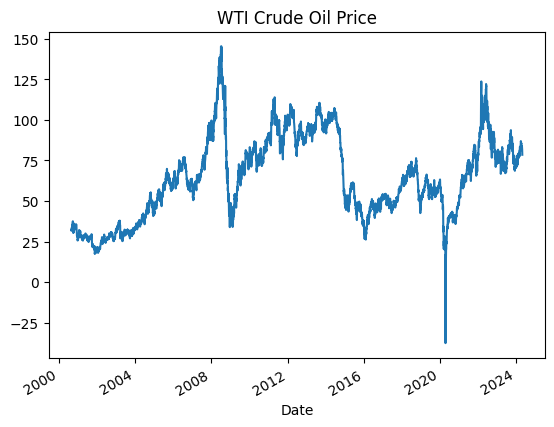

In [118]:
# WTI Crude Oil
# https://uk.finance.yahoo.com/quote/CL=F/
crude_oil_df = yf.download(tickers="CL=F", period="max", interval="1d")

crude_oil_df["Adj Close"].plot(title="WTI Crude Oil Price")
plt.show()

[*********************100%%**********************]  1 of 1 completed


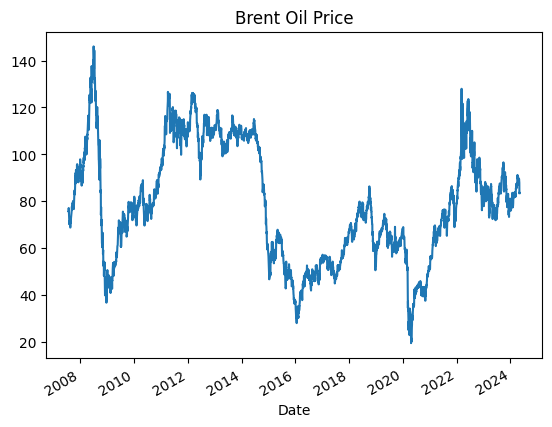

In [119]:
# WTI Crude Oil
# https://uk.finance.yahoo.com/quote/BZ=F/
brent_oil_df = yf.download(tickers="BZ=F", period="max", interval="1d")

brent_oil_df["Adj Close"].plot(title="Brent Oil Price")
plt.show()

[*********************100%%**********************]  1 of 1 completed


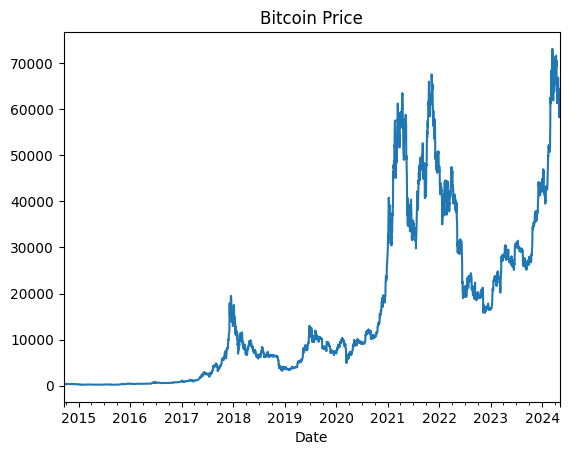

In [120]:
# Cryptocurrency: BTC
# https://finance.yahoo.com/quote/BTC-USD/
btc_usd_df = yf.download(tickers="BTC-USD", period="max", interval="1d")

btc_usd_df["Adj Close"].plot(title="Bitcoin Price")
plt.show()

In [123]:
# Euro yield curves; the service is slow, you need to specify addtional params
# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
filter_pars = {'startPeriod':'2024-04-01', 'endPeriod':'2024-05-01'}
eu_yield_df = eurostat.get_data_df(code="irt_euryld_d", flags=True, filter_pars=filter_pars, verbose=True)

Download progress: 100.0%



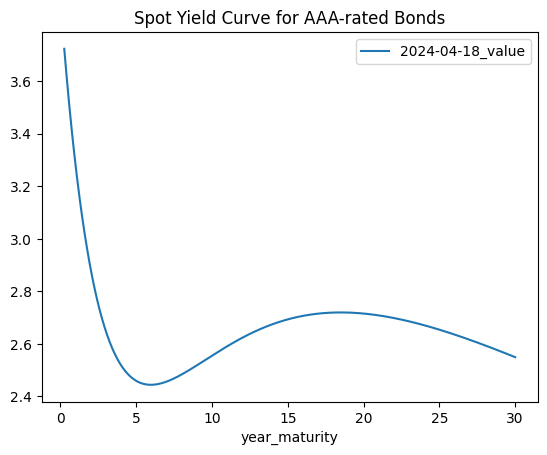

In [146]:
# Euro yield curves
# https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

def extract_yield_period(maturity):
    """
    Extract maturiy of yield in month period.
    """
    y_match = re.search(r"Y(\d+)", maturity)
    m_match = re.search(r"M(\d+)", maturity)

    y = int(y_match.group(1)) if y_match else 0
    m = int(m_match.group(1)) if m_match else 0

    return y * 12 + m

# Filter only spot rate and AAA rated bonds
spot_eu_aaa_bond_yield_df = eu_yield_df[(eu_yield_df["yld_curv"] == "SPOT_RT") & (eu_yield_df["bonds"] == "CGB_EA_AAA")].copy()

# Calculate maturity in months and years
spot_eu_aaa_bond_yield_df["month_maturity"] = spot_eu_aaa_bond_yield_df["maturity"].apply(lambda x: extract_yield_period(x))
spot_eu_aaa_bond_yield_df["year_maturity"] = spot_eu_aaa_bond_yield_df["month_maturity"] / 12

# Visualization
spot_eu_aaa_bond_yield_df.sort_values(by="month_maturity")[["year_maturity", "2024-04-18_value"]].plot(
    x="year_maturity", 
    y="2024-04-18_value", 
    title="Spot Yield Curve for AAA-rated Bonds"
)
plt.show()

### Fundamental Indicators

Fundamental analysis is all about the process of doing [ratio analysis](https://www.investopedia.com/terms/r/ratioanalysis.asp). Here we are using `yfinance` to download the latest 4-years of fundamental data. 

Please see potential data sources as following:

* [yFinance API Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/)
* [WSJ Market Data](https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement)
* [Guru Focus Data](https://www.gurufocus.com/stock/NVO/summary?search)

In [149]:
# Stock screener
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/
US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

wmt = yf.Ticker(US_TOP_EMPLOYEES_STOCKS[0])

In [151]:
wmt.calendar

{'Dividend Date': datetime.date(2025, 1, 6),
 'Ex-Dividend Date': datetime.date(2024, 5, 9),
 'Earnings Date': [datetime.date(2024, 5, 16)],
 'Earnings High': 0.51,
 'Earnings Low': 0.47,
 'Earnings Average': 0.49,
 'Revenue High': 149936000000,
 'Revenue Low': 146985000000,
 'Revenue Average': 148620000000}

In [150]:
wmt.earnings_dates

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-06-05 11:00:00-04:00,0.49,NaN,NaN
2025-02-20 08:00:00-05:00,NaN,NaN,NaN
2024-11-19 08:00:00-05:00,NaN,NaN,NaN
2024-08-15 08:00:00-04:00,NaN,NaN,NaN
2024-06-05 11:00:00-04:00,0.49,NaN,NaN
2024-05-16 08:00:00-04:00,0.49,NaN,NaN
2024-04-10 06:00:00-04:00,0.51,0.56,0.098
2024-04-03 06:00:00-04:00,0.51,0.56,0.098
2024-03-28 06:00:00-04:00,0.51,0.56,0.098


*EPS* appears on close earning dates. Therefore, it is suitable only for a short-term investment (before/after trading day).

In [156]:
wmt.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,-612140000.0,0.0
Tax Rate For Calcs,0.255,0.336,0.254,0.333
Normalized EBITDA,36384000000.0,30089000000.0,33758000000.0,34031000000.0
Total Unusual Items,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,15511000000.0,11680000000.0,13673000000.0,13510000000.0
Reconciled Depreciation,11853000000.0,10945000000.0,10658000000.0,11152000000.0
Reconciled Cost Of Revenue,490142000000.0,463721000000.0,429000000000.0,420315000000.0
EBITDA,36384000000.0,30089000000.0,31348000000.0,34031000000.0
EBIT,24531000000.0,19144000000.0,20690000000.0,22879000000.0


In [171]:
# Basic fundamental indicators
eps = wmt.financials.loc["Basic EPS"]
total_revenue = wmt.financials.loc["Total Revenue"]
ebitda = wmt.financials.loc["EBITDA"]
ebitda_margin = ebitda / total_revenue
net_income = wmt.financials.loc["Net Income"]
net_income_margin = net_income / total_revenue

fin_df = pd.DataFrame({
    "net_income_margin": net_income_margin * 100, 
    "ebitda_margin": ebitda_margin * 100, 
    "eps": eps
}).sort_index()

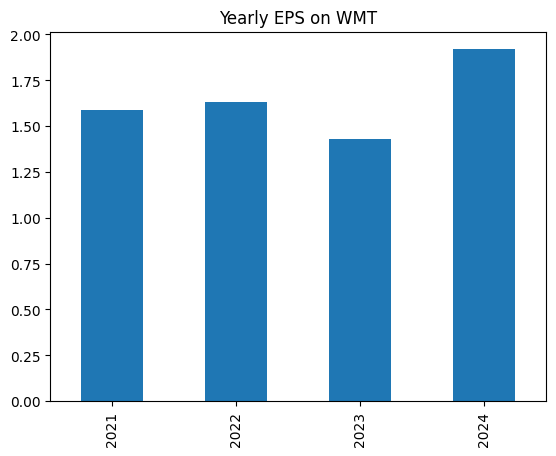

In [180]:
years = fin_df.index.year
fin_df["eps"].plot(kind="bar", title="Yearly EPS on WMT")

plt.xticks(range(len(years)), labels=years)
plt.show()

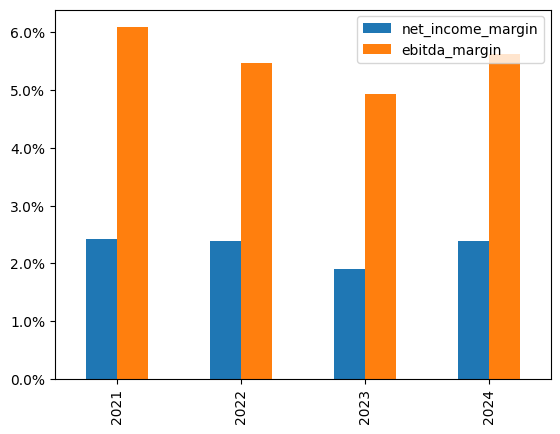

In [187]:
ax = fin_df[["net_income_margin", "ebitda_margin"]].plot(kind="bar")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(years)), labels=years)
plt.show()

### Technical Indicators

Unlike fundamental analysis, technical analysis uses historical prices and volumes to come up with indicators to identify the potential investment.

More details on technical indicators:

* [Top 5 Books to Learn Technical Analysis](https://www.investopedia.com/articles/personal-finance/090916/top-5-books-learn-technical-analysis.asp)
* [Financial Glossary](https://ycharts.com/glossary)

#### Simple Trading Strategy: SMA 10/20

We will use `pandas` to create necessary technical indicators for implementing [SMA 10/20](https://www.tradingview.com/chart/EURUSD/TXANiPQP-Simple-Trading-Strategy-10-20-SMA/) strategy. First we screen potential stocks in this case using market capitalization as a guideline.

Top 11 stocks using market capitalization:

* [US Stocks](https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/)
* [EU Stocks](https://companiesmarketcap.com/european-union/largest-companies-in-the-usa-by-market-cap/)
* [Indian Stocks](https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/)

In [188]:
# Stock screener via market capitalization
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [206]:
stocks_dfs = []
for ticker in US_STOCKS + EU_STOCKS + INDIA_STOCKS:
    history_df = yf.download(tickers=ticker, period="max", interval="1d")

    history_df = history_df.reset_index()
    history_df["Ticker"] = ticker

    history_df["SMA10"] = history_df["Close"].rolling(10).mean()
    history_df["SMA20"] = history_df["Close"].rolling(20).mean()
    history_df["is_growing_ma"] = np.where(history_df['SMA10'] > history_df['SMA20'], 1, 0)

    stocks_dfs.append(history_df)

    # Prevent overloading API server
    time.sleep(1)

stocks_df = pd.concat(stocks_dfs, ignore_index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

#### TA-Lib

We can use `TA-Lib` for calculating advanced technicator indicators easily. `TA-Lib` supports several [indicator groups](https://github.com/TA-Lib/ta-lib-python/blob/master/README.md#indicator-groups).

More on how to use `TA-Lib`:

* [Technical Indicators on Crypto and Stocks](https://pythoninvest.com/long-read/tech-indicators-on-crypto-and-stocks)
* [Snippet Code for 100+ technical indicator and patterns generation](https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb)

### Dataset

The goal is to have one big flat table with ~200-300 features and up to millions of timestamps and stocks. Duplicated and missing values should be checked thoroughly before using the dataset in the downstream process. Please use code snippet from [Module 2 Working with the data](02-dataframe-analysis/Module2_Colab_Working_with_the_data.ipynb) as a guidline to generate a completed dataset.